<a href="https://colab.research.google.com/github/dogukartal/IBM_AI_Labs/blob/main/Generative%20AI%20Language%20Modeling%20with%20Transformers/Breaking_Down_the_Transformer_for_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Applying Transformers for Classification**
---

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/Tokenization%20-%20Color.jpeg)


---


# Setup


In [ ]:
!pip install dash-core-components==2.0.0
!pip install dash-table==5.0.0
!pip install dash==2.9.3
!pip install -Uqq dash-html-components==2.0.0
!pip install -Uqq portalocker>=2.0.0
!pip install -Uqq plotly
!pip install -qq torch==2.0.0
!pip install -qq torchtext==0.15.1
!pip install -qq torchdata==0.6.0

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn

from sklearn.manifold import TSNE

from torch.utils.data import DataLoader
import numpy as np
from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md
from tqdm import tqdm

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from sklearn.manifold import TSNE
import plotly.graph_objs as go
import pickle

from torch.nn.utils.rnn import pad_sequence

In [2]:
def plot(COST,ACC):

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

In [3]:
def plot_embdings(my_embdings,name,vocab):

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Plot the data points
  ax.scatter(my_embdings[:,0], my_embdings[:,1], my_embdings[:,2])

  # Label the points
  for j, label in enumerate(name):
      i=vocab.get_stoi()[label]
      ax.text(my_embdings[j,0], my_embdings[j,1], my_embdings[j,2], label)

  # Set axis labels
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

  # Show the plot
  plt.show()

In [69]:
def plot_tras(words, model):
    # Tokenize the input words using a tokenizer function
    tokens = tokenizer(words)

    # Define the model's embedding dimension (d_model)
    d_model = 100

    # Convert the input words to a PyTorch tensor and move it to the specified device
    x = torch.tensor(text_pipeline(words)).unsqueeze(0).to(device)

    # Apply the model's embedding layer and scale the embeddings by sqrt(d_model)
    x_ = model.emb(x) * math.sqrt(d_model)

    # Apply the model's positional encoder to the embeddings
    x = model.pos_encoder(x_)

    # Extract projection weights for query, key, and value from the model's state_dict
    q_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][0:emsize].t()
    k_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][emsize:2*emsize].t()
    v_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][2*emsize:3*emsize].t()

    # Calculate query (Q), key (K), and value (V) matrices
    Q = (x @ q_proj_weight).squeeze(0)
    K = (x @ k_proj_weight).squeeze(0)
    V = (x @ v_proj_weight).squeeze(0)

    # Calculate attention scores using dot-product attention
    scores = Q @ K.T

    # Set row and column labels for the attention matrix
    row_labels = tokens
    col_labels = row_labels

    # Create a heatmap of the attention scores
    plt.figure(figsize=(10, 8))
    plt.imshow(scores.cpu().detach().numpy())
    plt.yticks(range(len(row_labels)), row_labels)
    plt.xticks(range(len(col_labels)), col_labels, rotation=90)
    plt.title("Dot-Product Attention")
    plt.show()

    # Apply softmax to the attention scores and create a heatmap
    att = nn.Softmax(dim=1)(scores)
    plt.figure(figsize=(10, 8))
    plt.imshow(att.cpu().detach().numpy())
    plt.yticks(range(len(row_labels)), row_labels)
    plt.xticks(range(len(col_labels)), col_labels, rotation=90)
    plt.title("Scaled Dot-Product Attention")
    plt.show()

    # Calculate the attention head by multiplying softmax scores with values (V)
    head = nn.Softmax(dim=1)(scores) @ V

    # Visualize the embeddings and attention heads using t-SNE
    tsne(x_, tokens, title="Embeddings")
    tsne(head, tokens, title="Attention Heads")


def tsne(embeddings, tokens, title="Embeddings"):
    # Initialize t-SNE with 2 components and a fixed random state
    tsne = TSNE(n_components=2, random_state=0)

    # Fit t-SNE to the embeddings (converting from GPU if necessary)
    tsne_result = tsne.fit_transform(embeddings.squeeze(0).cpu().detach().numpy())

    # Create a scatter plot of the t-SNE results
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1])

    # Set a title for the plot
    plt.title(title)

    # Add labels for each point in the scatter plot
    for j, label in enumerate(tokens):
        # Place the label text at the corresponding t-SNE coordinates
        plt.text(tsne_result[j, 0], tsne_result[j, 1], label)

    plt.show()

In [5]:
def save_list_to_file(lst, filename):
    """
    Save a list to a file using pickle serialization.

    Parameters:
        lst (list): The list to be saved.
        filename (str): The name of the file to save the list to.

    Returns:
        None
    """
    with open(filename, 'wb') as file:
        pickle.dump(lst, file)

def load_list_from_file(filename):
    """
    Load a list from a file using pickle deserialization.

    Parameters:
        filename (str): The name of the file to load the list from.

    Returns:
        list: The loaded list.
    """
    with open(filename, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

## Dataset


In [6]:
dataset = [
    (1,"Introduction to NLP"),
    (2,"Basics of PyTorch"),
    (1,"NLP Techniques for Text Classification"),
    (3,"Named Entity Recognition with PyTorch"),
    (3,"Sentiment Analysis using PyTorch"),
    (3,"Machine Translation with PyTorch"),
    (1,"NLP Named Entity,Sentiment Analysis, Machine Translation"),
    (1,"Machine Translation with NLP"),
    (1,"Named Entity vs Sentiment Analysis NLP"),
    (3,"He painted the car red"),
    (1,"He painted the red car")
    ]

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for  _,text in data_iter:
        yield tokenizer(text)

def text_pipeline(x):
  return vocab(tokenizer(x))

def label_pipeline(x):
   return int(x) - 1

vocab = build_vocab_from_iterator(yield_tokens(dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])


## Zero padding


In [7]:
sequences = [torch.tensor([j for j in range(1,i)]) for i in range(2,10)]
sequences

[tensor([1]),
 tensor([1, 2]),
 tensor([1, 2, 3]),
 tensor([1, 2, 3, 4]),
 tensor([1, 2, 3, 4, 5]),
 tensor([1, 2, 3, 4, 5, 6]),
 tensor([1, 2, 3, 4, 5, 6, 7]),
 tensor([1, 2, 3, 4, 5, 6, 7, 8])]

In [8]:
padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
print(padded_sequences)

tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [1, 2, 0, 0, 0, 0, 0, 0],
        [1, 2, 3, 0, 0, 0, 0, 0],
        [1, 2, 3, 4, 0, 0, 0, 0],
        [1, 2, 3, 4, 5, 0, 0, 0],
        [1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])


## Positional Encodings

In [11]:
my_tokens = 'he painted the car red he painted the red car'

my_index = text_pipeline(my_tokens)

embedding_dim=3

vocab_size=  len(vocab)

embedding = nn.Embedding(vocab_size, embedding_dim)

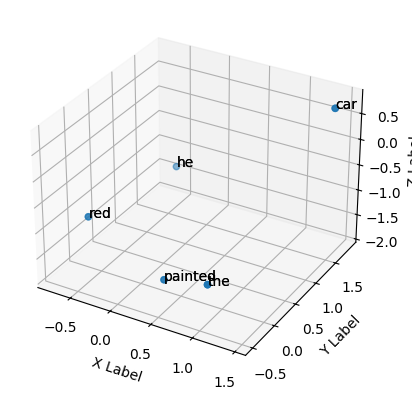

In [10]:
my_embdings = embedding(torch.tensor(my_index)).detach().numpy()
plot_embdings(my_embdings,tokenizer(my_tokens), vocab)

In [12]:
position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
position

tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [15.],
        [16.],
        [17.],
        [18.],
        [19.],
        [20.],
        [21.],
        [22.],
        [23.],
        [24.],
        [25.],
        [26.]])

In [13]:
d_model = 3
pe = torch.zeros(vocab_size,d_model )

In [14]:
pe = torch.cat((position, position, position), 1)
pe

tensor([[ 0.,  0.,  0.],
        [ 1.,  1.,  1.],
        [ 2.,  2.,  2.],
        [ 3.,  3.,  3.],
        [ 4.,  4.,  4.],
        [ 5.,  5.,  5.],
        [ 6.,  6.,  6.],
        [ 7.,  7.,  7.],
        [ 8.,  8.,  8.],
        [ 9.,  9.,  9.],
        [10., 10., 10.],
        [11., 11., 11.],
        [12., 12., 12.],
        [13., 13., 13.],
        [14., 14., 14.],
        [15., 15., 15.],
        [16., 16., 16.],
        [17., 17., 17.],
        [18., 18., 18.],
        [19., 19., 19.],
        [20., 20., 20.],
        [21., 21., 21.],
        [22., 22., 22.],
        [23., 23., 23.],
        [24., 24., 24.],
        [25., 25., 25.],
        [26., 26., 26.]])

In [16]:
samples, dim = my_embdings.shape
samples, dim

(10, 3)

In [17]:
pos_embding=my_embdings+pe[0:samples,:].numpy()

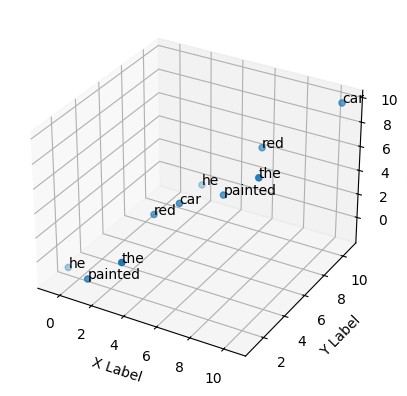

In [18]:
# With positional encodings
plot_embdings(pos_embding,tokenizer(my_tokens),vocab)

In [19]:
# "car" embedding at position 3 and 9 differ excessively which may cause divergence
pos_embding[3] # add -3 to get original embedding

array([4.4625435, 4.6921086, 3.7668   ], dtype=float32)

In [20]:
pos_embding[-1] # add -9 original embedding

array([10.4625435, 10.692108 ,  9.7668   ], dtype=float32)

You can address this magnitude issue through various approaches. Firstly, you can employ a function that doesn't exhibit such significant amplification. Additionally, you have the option to introduce different functions. For instance, when considering your word positional encodings, the magnitude of the positional encodings $\textbf{p}_{n,d}$ can be represented as $[p_{n,1}, p_{n,2}, p_{n,3}]$, which, in this case, translates to $[0.1n, -0.1n, 1]$.


In [21]:
pe = torch.cat((0.1*position, -0.1*position, 0*position), 1)

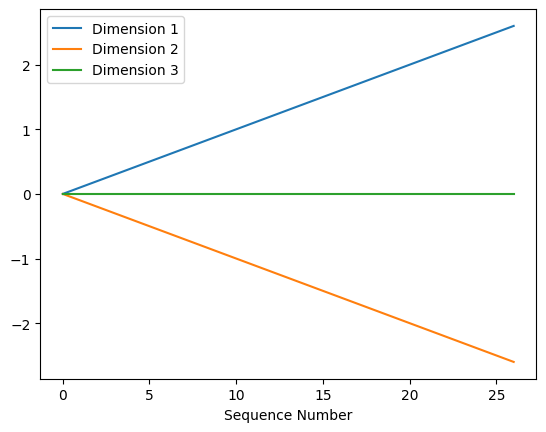

In [22]:
plt.plot(pe[:, 0].numpy(), label="Dimension 1")
plt.plot(pe[:, 1].numpy(), label="Dimension 2")
plt.plot(pe[:, 2].numpy(), label="Dimension 3")

plt.xlabel("Sequence Number")
plt.legend()
plt.show()

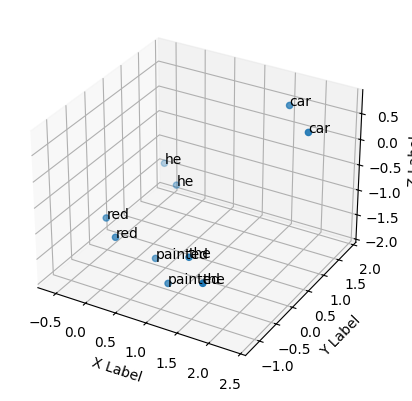

In [23]:
# Linear Positional Encoding
pos_embding = my_embdings + pe[0:samples,:].numpy()
plot_embdings(pos_embding,tokenizer(my_tokens), vocab)

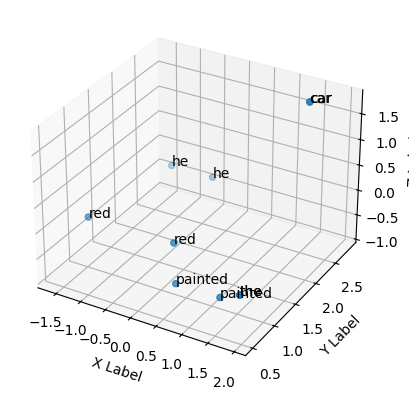

In [24]:
# Periodic Nonlinear Positional Encoding
pe = torch.cat((torch.sin(2*3.14*position/6), 0*position+1, 0*position+1), 1)
pos_embding = my_embdings+pe[0:samples,:].numpy()
plot_embdings(pos_embding,tokenizer(my_tokens),vocab)

In [25]:
pe

tensor([[ 0.0000,  1.0000,  1.0000],
        [ 0.8658,  1.0000,  1.0000],
        [ 0.8666,  1.0000,  1.0000],
        [ 0.0016,  1.0000,  1.0000],
        [-0.8650,  1.0000,  1.0000],
        [-0.8673,  1.0000,  1.0000],
        [-0.0032,  1.0000,  1.0000],
        [ 0.8642,  1.0000,  1.0000],
        [ 0.8681,  1.0000,  1.0000],
        [ 0.0048,  1.0000,  1.0000],
        [-0.8634,  1.0000,  1.0000],
        [-0.8689,  1.0000,  1.0000],
        [-0.0064,  1.0000,  1.0000],
        [ 0.8626,  1.0000,  1.0000],
        [ 0.8697,  1.0000,  1.0000],
        [ 0.0080,  1.0000,  1.0000],
        [-0.8617,  1.0000,  1.0000],
        [-0.8705,  1.0000,  1.0000],
        [-0.0096,  1.0000,  1.0000],
        [ 0.8609,  1.0000,  1.0000],
        [ 0.8713,  1.0000,  1.0000],
        [ 0.0111,  1.0000,  1.0000],
        [-0.8601,  1.0000,  1.0000],
        [-0.8721,  1.0000,  1.0000],
        [-0.0127,  1.0000,  1.0000],
        [ 0.8593,  1.0000,  1.0000],
        [ 0.8728,  1.0000,  1.0000]])

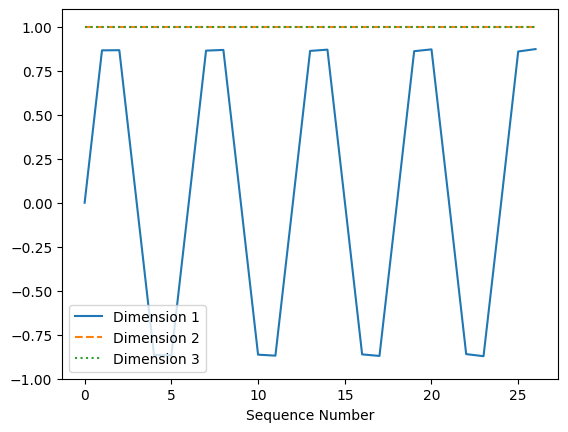

In [26]:
# Plot the positional encodings with different line styles and markers
plt.plot(pe[:, 0].numpy(), label="Dimension 1", linestyle='-')
plt.plot(pe[:, 1].numpy(), label="Dimension 2", linestyle='--')
plt.plot(pe[:, 2].numpy(), label="Dimension 3", linestyle=':')

# Adjust the y-axis scale for better visibility
plt.ylim([-1, 1.1])

plt.xlabel("Sequence Number")
plt.legend()
plt.show()

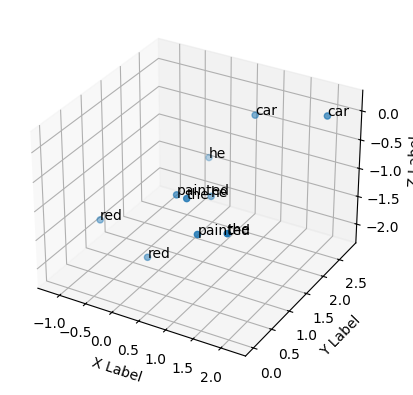

In [27]:
pe=torch.cat((torch.cos(2*3.14*position/25), torch.sin(2*3.14*position/25),  torch.sin(2*3.14*position/5)), 1)
pos_embding=my_embdings+pe[0:samples,:].numpy()
plot_embdings(pos_embding,tokenizer(my_tokens),vocab)

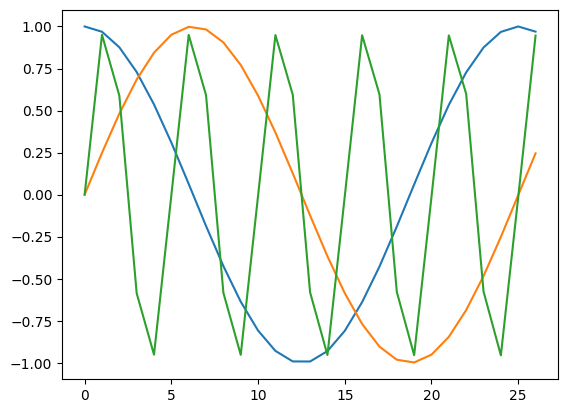

In [28]:
plt.plot(pe[:, 0].numpy(), label="Dimension 1")
plt.plot(pe[:, 1].numpy(), label="Dimension 2")
plt.plot(pe[:, 2].numpy(), label="Dimension 3")

In [29]:
from torch import nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()

        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

## Text classification

In [34]:
# Dataset
train_iter= AG_NEWS(split="train")
y, text= next(iter(train_iter ))
print(y, text)

3 Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


In [35]:
# Labels
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
ag_news_label[y]

'Business'

In [36]:
num_class = len(set([label for (label, text) in train_iter ]))
num_class

4

In [38]:
# Building Vocab
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [39]:
vocab(["age","hello"])

[2120, 12544]

In [40]:
# Split the dataset into training and testing iterators.
train_iter, test_iter = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Data loader


In [42]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))


    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)


    return label_list.to(device), text_list.to(device)

In [43]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [45]:
label, seqence = next(iter(valid_dataloader ))

### Neural network


In [46]:
class Net(nn.Module):
    """
    Text classifier based on a pytorch TransformerEncoder.
    """

    def __init__(

        self,
        vocab_size,
        num_class,
        embedding_dim = 100,
        nhead = 5,
        dim_feedforward = 2048,
        num_layers = 6,
        dropout = 0.1,
        activation = "relu",
        classifier_dropout = 0.1):

        super().__init__()

        self.emb = nn.Embedding(vocab_size,embedding_dim)

        self.pos_encoder = PositionalEncoding(
            d_model=embedding_dim,
            dropout=dropout,
            vocab_size=vocab_size,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(embedding_dim, num_class)
        self.d_model = embedding_dim

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

In [47]:
y, x = next(iter(train_dataloader))

In [48]:
x

tensor([[ 1988,    12,     9,  ...,     0,     0,     0],
        [ 7537,     7,    70,  ...,     0,     0,     0],
        [ 1466,   118,   381,  ...,     0,     0,     0],
        ...,
        [ 4435,    10,  9264,  ...,     0,     0,     0],
        [ 3085, 16625,   745,  ...,     0,     0,     0],
        [12743,   378,  1068,  ...,     0,     0,     0]], device='cuda:0')

In [49]:
emsize = 64
vocab_size = len(vocab)
vocab_size

In [52]:
model = Net(vocab_size=vocab_size,num_class=4).to(device)
model

Net(
  (emb): Embedding(95811, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=100, out_features=4, bias=True)
)

In [54]:
predicted_label = model(x)
predicted_label.shape

torch.Size([64, 4])

In [55]:
x.shape

torch.Size([64, 76])

In [56]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)

        output = model(text)
        return ag_news_label[output.argmax(1).item() + 1]

In [57]:
predict("I like sports and stuff",text_pipeline )

'Sci/Tec'

In [59]:
# Evaluater Function
def evaluate(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model_eval(text.to(device))

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [60]:
evaluate(test_dataloader, model)

0.24118421052631578

## Training

In [61]:
LR=0.1

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [63]:
EPOCHS = 10
cum_loss_list=[]
acc_epoch=[]
acc_old=0

for epoch in tqdm(range(1, EPOCHS + 1)):
    model.train()
    cum_loss=0
    for idx, (label, text) in enumerate(train_dataloader):
        optimizer.zero_grad()
        label, text=label.to(device), text.to(device)

        predicted_label = model(text)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        cum_loss+=loss.item()

    print("Loss",cum_loss)

    cum_loss_list.append(cum_loss)
    accu_val = evaluate(valid_dataloader, model)
    acc_epoch.append(accu_val)

    if accu_val > acc_old:
      acc_old= accu_val
      torch.save(model.state_dict(), 'my_model.pth')

save_list_to_file(lst=cum_loss_list, filename="loss.pkl")
save_list_to_file(lst=acc_epoch, filename="acc.pkl")

  0%|          | 0/10 [00:00<?, ?it/s]

Loss 2348.7328124046326


 10%|█         | 1/10 [01:50<16:31, 110.16s/it]

Loss 2227.187074303627


 20%|██        | 2/10 [03:40<14:43, 110.47s/it]

Loss 2121.758624792099


 30%|███       | 3/10 [05:30<12:50, 110.07s/it]

Loss 2026.5463448762894


 40%|████      | 4/10 [07:20<10:59, 109.87s/it]

Loss 1933.3001809716225


 50%|█████     | 5/10 [09:09<09:09, 109.82s/it]

Loss 1837.519321322441


 60%|██████    | 6/10 [10:59<07:18, 109.73s/it]

Loss 1744.4729877114296


 70%|███████   | 7/10 [12:49<05:29, 109.99s/it]

Loss 1658.461762368679


 80%|████████  | 8/10 [14:39<03:39, 109.85s/it]

Loss 1579.9644111394882


 90%|█████████ | 9/10 [16:29<01:50, 110.05s/it]

Loss 1511.6577958464622


100%|██████████| 10/10 [18:19<00:00, 109.93s/it]


In [64]:
cum_loss_list = load_list_from_file("loss.pkl")
acc_epoch = load_list_from_file("acc.pkl")

In [65]:
pretrained_model_path = 'my_model.pth'
model_ = Net(vocab_size=vocab_size, num_class=4).to(device)
model_.load_state_dict(torch.load(pretrained_model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

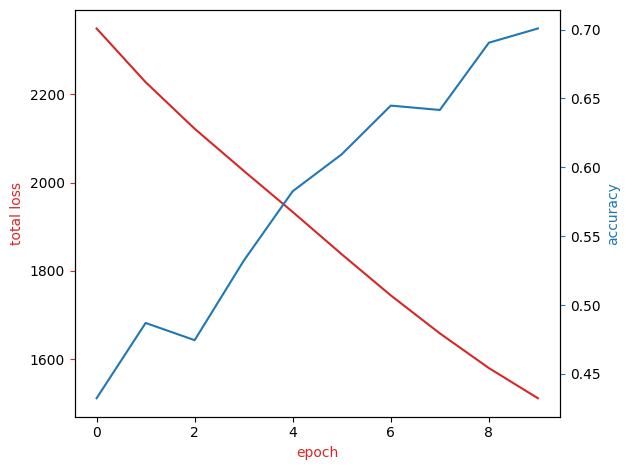

In [66]:
plot(cum_loss_list,acc_epoch)

In [67]:
evaluate(test_dataloader, model_)

0.7019736842105263

The `plot_tras` function takes input words and a transformer model as arguments. It tokenizes the input words, applies the model's embedding and positional encoding layers, and extracts projection weights for query, key, and value from the model's state_dict. Using dot-product attention, it computes and visualizes attention scores as a heatmap. The softmax of these scores is also visualized as a separate heatmap. The function calculates the attention head by multiplying softmax scores with values and employs t-SNE to visualize both the embeddings and attention heads, offering insights into the attention mechanisms within the transformer model.


Rescuing an Old Saver If you think you may need to help your elderly relatives with their finances, don't be shy about having the money talk -- soon.


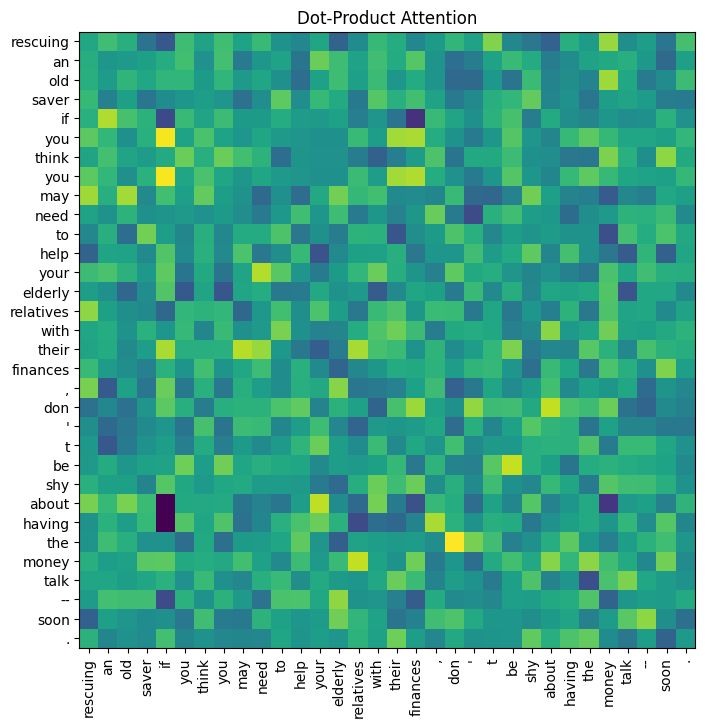

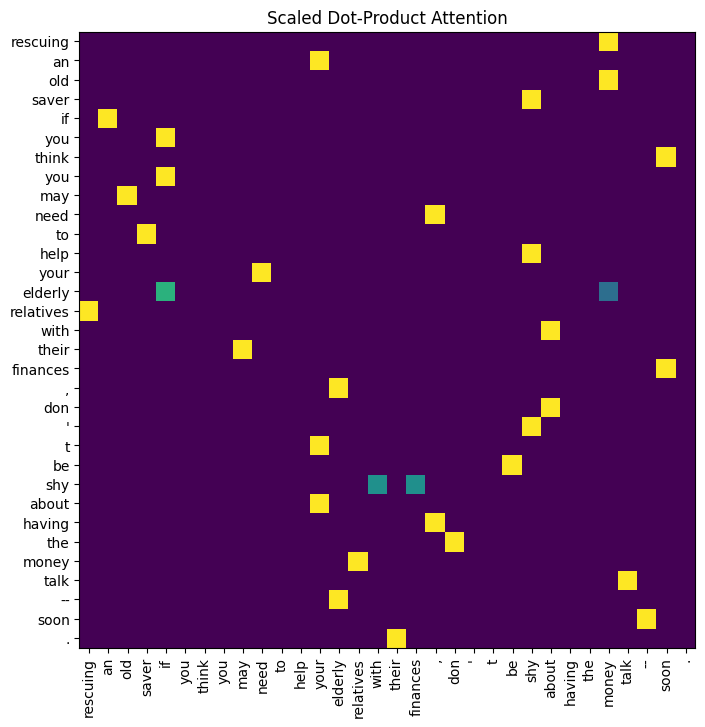

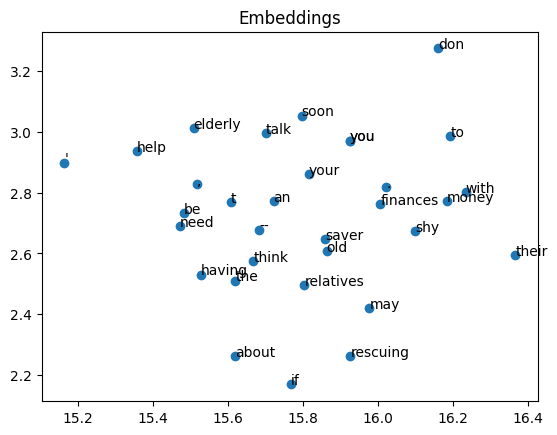

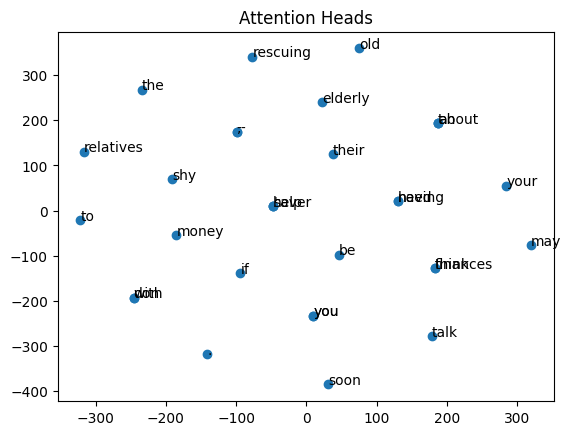

In [70]:
sample=15

words = train_dataset[sample][1]
print(words)
plot_tras(words, model)

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.


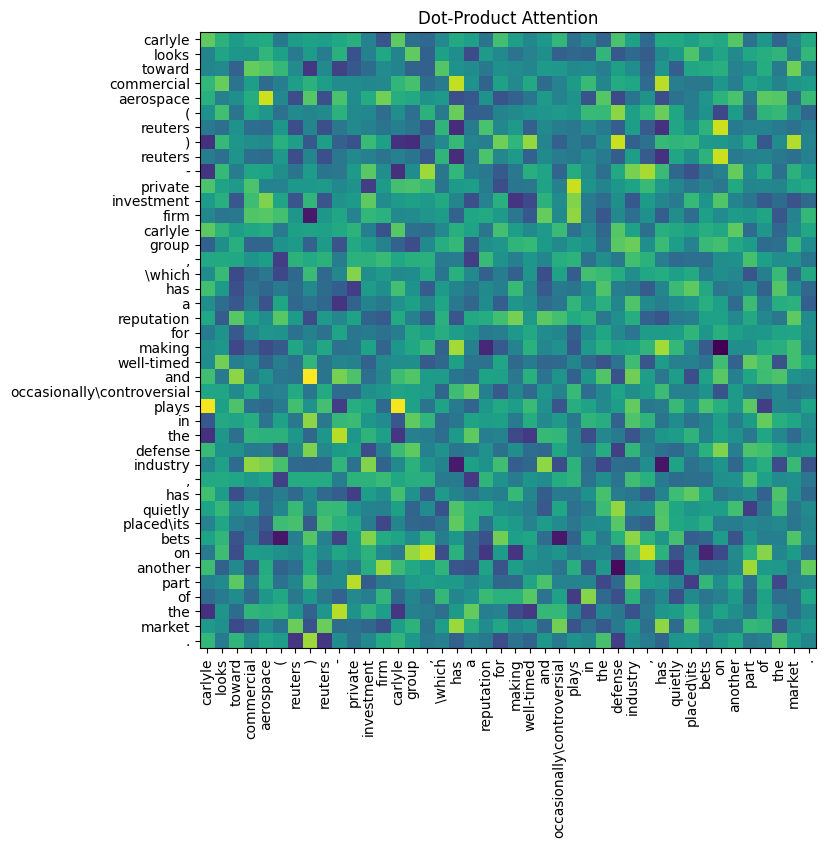

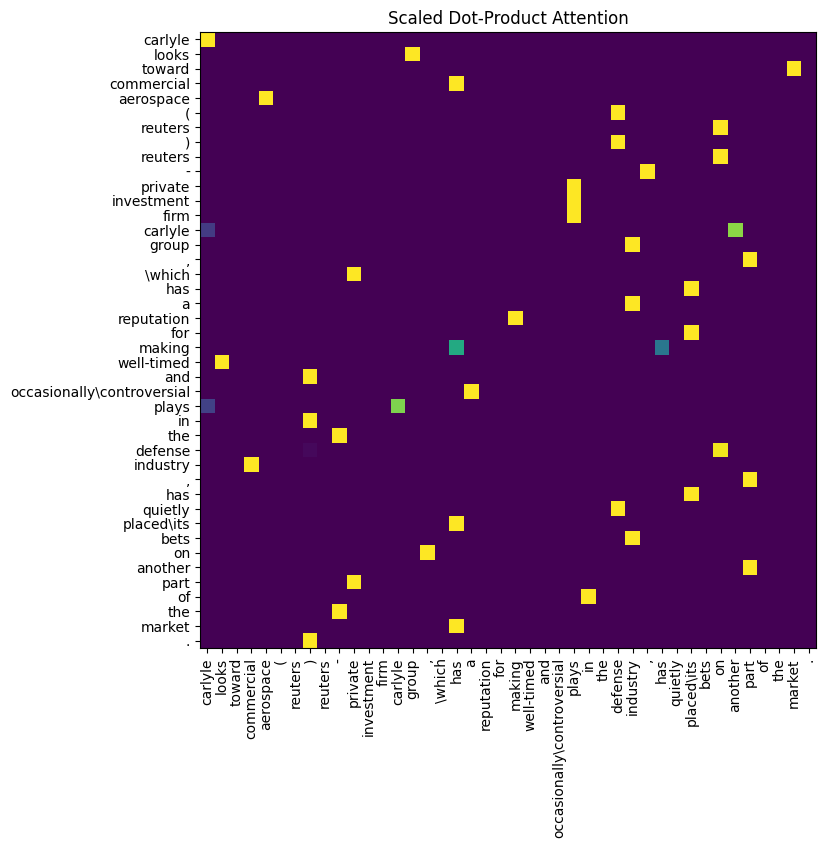

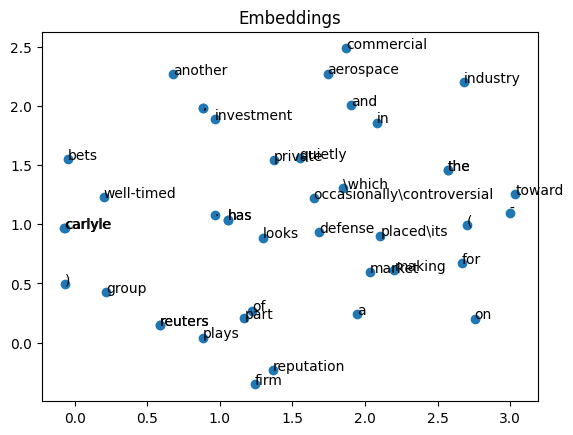

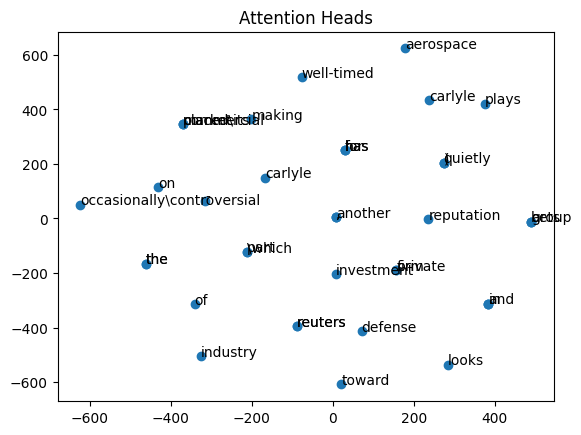

In [71]:
sample=1

words=train_dataset[sample][1]
print(words)
plot_tras(words, model)